# Import librairies

In [13]:
from gensim import corpora
from gensim import models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

from motifs.dataloader import CanonData
from motifs.features import bow_to_matrix
from motifs.utils import filter_token_by_freq

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from motifs.pipeline import Pipeline
from motifs.features import build_tfidf, transform_corpus_to_ngrams
from motifs.utils import build_window_corpus, return_to_text_from_token

# Load data

- Get metadata
- Load the 5-grams that were precomputed using a subcorpus of the "canon" corpus.
    - This subcorpus was built by selecting at most 50 texts at random per period, which are defined in `motifs.dataloader.CanonData`, e.g 1800-1826, 1827-1850, 1851-1869, 1870-1899, 1900-1945, 1946-2024.
    - We have in total 217 documents
    - Remove tokens that appear only once in each document in the corpus

In [5]:
NGRAMS_PATH = "/Users/brunospilak/Documents/Sorbonne/PyMotifs/data_backup/ngrams_canon.csv"
METADATA_PATH = "../data/canon/metadata.csv"

In [23]:
# Load metadata
metadata = CanonData(METADATA_PATH)
data = metadata.data.set_index("doc_id")

# Load 5-grams, about 1.6GB in RAM
ngrams = pd.read_csv(NGRAMS_PATH, index_col=0)
docs = list(set(ngrams.doc.unique()))
# Get the metadata for the subcorpus
data = data.loc[docs]

# Remove tokens that appear only once, this can take a while since ngrams has more than 15 Million rows
t1 = time.time()
ngrams = filter_token_by_freq(ngrams, 1, groupby="doc")
t2 = time.time()
print(f"Done in {t2-t1:.2f} secs")

Done in 74.90 secs


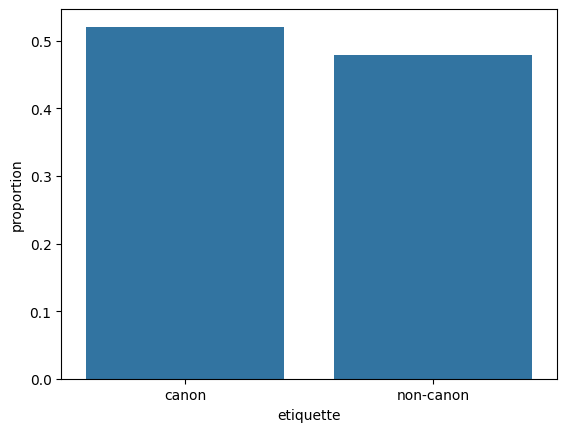

,doc,token,word,text,target
0,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les regards de les agens,non-canon
1,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,le,le nom de le conseil,non-canon
2,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,la,la bienfaisance de le dieu,non-canon
3,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les habitans de le royaume,non-canon
4,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les fers de l' étranger,non-canon
...,...,...,...,...,...
4848684,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC de,serait,serait un vrai coup de,non-canon
4848685,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC que,est,est un charmant garçon que,non-canon
4848686,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC que,est,est un vrai roman que,non-canon
4848687,1971_Veuzit-Max-du_Rien-qu'une-nuit,"être un NC , un",est,"est une bombe , un",non-canon


In [27]:
# Add target variable
sns.countplot(data, x="etiquette", stat="proportion")
plt.show()
ngrams = ngrams.set_index("doc").join(data["etiquette"]).reset_index().rename({"etiquette": "target"}, axis=1)
ngrams

# Train/test split

We split with respect to the documents, having different document in train and test, but keeping the class distribution in train and test samples.

In [34]:
test_size = 0.3
random_state = 0 # For reproducibility
# Use StratifiedShuffleSplit to keep class balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
train_docs, test_docs = list(sss.split(data.index, data.etiquette))[0]
train_docs = data.index[train_docs].tolist()
test_docs = data.index[test_docs].tolist()
print(len(train_docs), len(test_docs))

t1 = time.time()
train_data = ngrams[ngrams["doc"].isin(train_docs)]
test_data = ngrams[ngrams["doc"].isin(test_docs)]
t2 = time.time()
print(f"{t2-t1:.2f}")

(151, 66)

In [35]:
ngrams

,doc,token,word,text,target
0,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les regards de les agens,non-canon
1,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,le,le nom de le conseil,non-canon
2,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,la,la bienfaisance de le dieu,non-canon
3,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les habitans de le royaume,non-canon
4,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les fers de l' étranger,non-canon
...,...,...,...,...,...
4848684,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC de,serait,serait un vrai coup de,non-canon
4848685,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC que,est,est un charmant garçon que,non-canon
4848686,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC que,est,est un vrai roman que,non-canon
4848687,1971_Veuzit-Max-du_Rien-qu'une-nuit,"être un NC , un",est,"est une bombe , un",non-canon


0.59
